# Getting sequence data

In this section, we outline the process of extracting sequence data from text. In particular, we will extract character sequences from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35), a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline.

## Processing the sample text

In [1]:
!mkdir ./data
!curl "https://www.gutenberg.org/cache/epub/35/pg35.txt" --output ./data/time_machine.txt

mkdir: ./data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   104k      0  0:00:01  0:00:01 --:--:--  104k


This has some boilerplate text by [Project Gutenberg](https://www.gutenberg.org/)[^1] that we have to remove:

[^1]: Project Gutenberg is an excellent source of literary text data. Moreover, the preprocessing steps for `.txt` files are very similar for each text.

In [2]:
text = open("./data/time_machine.txt").read()
print(text[:891])

The Project Gutenberg eBook of The Time Machine
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Time Machine

Author: H. G. Wells

Release date: October 2, 2004 [eBook #35]
                Most recently updated: March 30, 2021

Language: English



*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***




The Time Machine

An Invention

by H. G. Wells


CONTENTS

 I Introduction
 II The Machine
 III The Time Traveller Returns
 IV Time Travelling
 V In the Golden Age


Simply find the start and end of the Project Gutenberg markers:

In [3]:
start = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
end = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
text = text[text.find(start) + len(start): text.find(end)]
print(len(text.split()))
print(text[:129].strip())
print("...\n")
print(text[-95:].strip())

32453
The Time Machine

An Invention

by H. G. Wells


CONTENTS

 I Introduction
 II The Machine
 III The Time Traveller Returns
...

strength had gone, gratitude and a mutual tenderness
still lived on in the heart of man.


<br>

## Tokenization

Tokens are the *atomic* units of text. Each time step corresponds to one token, but what it is that constitutes a token is a design choice. For example, we can represent the sentence "Deep learning is fun" as a sequence of 4 tokens, with one token for every English word. Then, the set of all words comprise a large vocabulary (typically ~10-100K words). 
Or we can represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (256 ASCII characters). There is some tradeoff associated with the choice of **vocabulary**[^2]. 

Our implementation of the **tokenizer** builds[^3] the vocabulary from the text which is represented as a single large string. Tokenization implemented as `tokenize` refers to converting a string to a list of tokens. The vocabulary refers to the list of all tokens. Finally, the tokenizer implements an `encode` method which converts a string to a list of integer indices, and a `decode` method which converts a list of integers to a string.

[^2]: For example, using a larger vocabulary provides richer, context-aware understanding compared to ASCII-based tokenization. ASCII-only tokenization, such as treating each character as a token, loses essential semantic and syntactic information. Tokenization has [profound implications](https://x.com/karpathy/status/1759996551378940395) which we will cover in a future chapter.

[^3]: In practice, [standard vocabularies](https://huggingface.co/docs/transformers/en/tokenizer_summary) already exist and are re-used for various use cases.

In [4]:
%%save
import re
from collections import Counter
from typing import Union, Optional, TypeVar, List

T = TypeVar("T")
ScalarOrList = Union[T, List[T]]


class Vocab:
    def __init__(self, 
        text: str, 
        min_freq: int = 0, 
        reserved_tokens: Optional[List[str]] = None,
        preprocess: bool = True
    ):
        text = self.preprocess(text) if preprocess else text
        tokens = list(text)
        counter = Counter(tokens)
        reserved_tokens = reserved_tokens or []
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itos = [self.unk_token] + reserved_tokens + [tok for tok, f in filter(lambda tokf: tokf[1] >= min_freq, self.token_freqs)]
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}

    def __len__(self):
        return len(self.itos)
    
    def __getitem__(self, tokens: ScalarOrList[str]) -> ScalarOrList[int]:
        if isinstance(tokens, str):
            return self.stoi.get(tokens, self.unk)
        else:
            return [self.__getitem__(tok) for tok in tokens]

    def to_tokens(self, indices: ScalarOrList[int]) -> ScalarOrList[str]:
        if isinstance(indices, int):
            return self.itos[indices]
        else:
            return [self.itos[int(index)] for index in indices]
            
    def preprocess(self, text: str):
        return re.sub("[^A-Za-z]+", " ", text).lower().strip()

    @property
    def unk_token(self) -> str:
        return "▮"

    @property
    def unk(self) -> int:
        return self.stoi[self.unk_token]

    @property
    def tokens(self) -> List[int]:
        return self.itos

import re
from collections import Counter
from typing import Union, Optional, TypeVar, List

T = TypeVar("T")
ScalarOrList = Union[T, List[T]]


class Vocab:
    def __init__(self, 
        text: str, 
        min_freq: int = 0, 
        reserved_tokens: Optional[List[str]] = None,
        preprocess: bool = True
    ):
        text = self.preprocess(text) if preprocess else text
        tokens = list(text)
        counter = Counter(tokens)
        reserved_tokens = reserved_tokens or []
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itos = [self.unk_token] + reserved_tokens + [tok for tok, f in filter(lambda tokf: tokf[1] >= min_freq, self.token_freqs)]
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}

    def __len__(self):
        return len(self.itos)
    
    def __getitem__(self, tokens: ScalarOrList[str]) -> ScalarOrList[int]:
        if isinstance(tokens, str):
            return self.stoi.get(tokens, self.unk)
        else:
            return [self.__getitem__(tok) for tok in tokens]

    def to_tokens(self, indices: ScalarOrList[int]) -> ScalarOrList[str]:
        if isinstance(indices, int):
            return self.itos[indices]
        else:
            return [self.itos[int(index)] for index in indices]
            
    def preprocess(self, text: str):
        return re.sub("[^A-Za-z]+", " ", text).lower().strip()

    @property
    def unk_token(self) -> str:
        return "▮"

    @property
    def unk(self) -> int:
        return self.stoi[self.unk_token]

    @property
    def tokens(self) -> List[int]:
        return self.itos

For simplicity (i.e. to get smaller models), the source text is preprocessed by removing punctuation and ignoring capitalization. This results in a significantly smaller vocabulary, trading off punctuation and capitalization which are important for text understanding and generating nuanced text.

In [5]:
%%save
import torch

class Tokenizer:
    def __init__(self, vocab: Vocab):
        self.vocab = vocab

    def tokenize(self, text: str) -> List[str]:
        UNK = self.vocab.unk_token
        tokens = self.vocab.stoi.keys()
        return [c if c in tokens else UNK for c in list(text)]

    def encode(self, text: str) -> torch.Tensor:
        x = self.vocab[self.tokenize(text)]
        return torch.tensor(x, dtype=torch.int64)

    def decode(self, indices: Union[ScalarOrList[int], torch.Tensor]) -> str:
        return "".join(self.vocab.to_tokens(indices))

    @property
    def vocab_size(self) -> int:
        return len(self.vocab)

import torch

class Tokenizer:
    def __init__(self, vocab: Vocab):
        self.vocab = vocab

    def tokenize(self, text: str) -> List[str]:
        UNK = self.vocab.unk_token
        tokens = self.vocab.stoi.keys()
        return [c if c in tokens else UNK for c in list(text)]

    def encode(self, text: str) -> torch.Tensor:
        x = self.vocab[self.tokenize(text)]
        return torch.tensor(x, dtype=torch.int64)

    def decode(self, indices: Union[ScalarOrList[int], torch.Tensor]) -> str:
        return "".join(self.vocab.to_tokens(indices))

    @property
    def vocab_size(self) -> int:
        return len(self.vocab)

Since our vocab includes only lowercase letters, 
the unknown token ▮ replaces missing characters when we encode the text:

In [6]:
text = open("./data/time_machine.txt").read()
vocab = Vocab(text)
tokenizer = Tokenizer(vocab)
print("vocab:", ", ".join(vocab.itos[:10]) + ", ...")
print("tokenization:", tokenizer.tokenize("Hello!"))
print("encoding-decoding:", "\nHello! ->", tokenizer.encode("Hello!"), "->", tokenizer.decode(tokenizer.encode("Hello!")))

vocab: ▮,  , e, t, a, i, o, n, s, r, ...
tokenization: ['▮', 'e', 'l', 'l', 'o', '▮']
encoding-decoding: 
Hello! -> tensor([ 0,  2, 12, 12,  6,  0]) -> ▮ello▮


Defining the class for processing the dataset:

In [7]:
%%save
import re
import os
import requests

from pathlib import Path

DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)


class TimeMachine:
    def __init__(self, download=False, path=None):
        DEFAULT_PATH = str((DATA_DIR / "time_machine.txt").absolute())
        self.filepath = path or DEFAULT_PATH
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _load_text(self):
        with open(self.filepath, "r") as f:
            text = f.read()
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        return text[text.find(s) + len(s): text.find(e)]
    
    def build(self, vocab: Optional[Vocab] = None):
        self.text = self._load_text()
        vocab = vocab or Vocab(self.text)
        tokenizer = Tokenizer(vocab)
        encoded_text = tokenizer.encode(vocab.preprocess(self.text))
        return encoded_text, tokenizer

import re
import os
import requests

from pathlib import Path

DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)


class TimeMachine:
    def __init__(self, download=False, path=None):
        DEFAULT_PATH = str((DATA_DIR / "time_machine.txt").absolute())
        self.filepath = path or DEFAULT_PATH
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _load_text(self):
        with open(self.filepath, "r") as f:
            text = f.read()
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        return text[text.find(s) + len(s): text.find(e)]
    
    def build(self, vocab: Optional[Vocab] = None):
        self.text = self._load_text()
        vocab = vocab or Vocab(self.text)
        tokenizer = Tokenizer(vocab)
        encoded_text = tokenizer.encode(vocab.preprocess(self.text))
        return encoded_text, tokenizer

Basic usage starts with download and then build:

In [8]:
tm = TimeMachine(download=True)
encoded_text, tokenizer = tm.build()

The `encoded_text` is the encoded clean text. This will be used later as training data.

In [9]:
print(len(encoded_text), tokenizer.vocab_size)
print(tokenizer.decode(encoded_text[:100]) + "...")

174215 28
the time machine an invention by h g wells contents i introduction ii the machine iii the time trave...


<br>

## Appendix: Project Gutenberg Reader

In this section, we generalize the `TimeMachine` class to read any title in Project Gutenberg.

In [10]:
import re
import os
import requests

ENCODING = "utf-8-sig"


class ProjectGutenberg:
    def __init__(self, url: str, data_dir: str, download=False, token_level="char"):
        self.token_level = token_level
        self.filepath = f"{data_dir}/{url.split('/')[-1]}"
        if download or not os.path.exists(self.filepath):
            self.download(url, self.filepath)

    @staticmethod
    def get_title(filepath):
        with open(filepath, "r", encoding=ENCODING) as f:
            line = f.readline()
        prefix = "The Project Gutenberg eBook of"
        return line.replace(prefix, "").strip()

    @staticmethod
    def download(url, filepath):
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(filepath, "wb") as output:
            output.write(response.content)
        
    @staticmethod
    def preprocess(text: str, title: str):
        s = f"*** START OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        e = f"*** END OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    @staticmethod
    def tokenize(text: str, token_level="char"):
        return list(text) if token_level == "char" else text.split()

    def build(self, vocab=None):
        with open(self.filepath, "r", encoding=ENCODING) as f:
            raw_text = f.read()
        
        self.title = self.get_title(self.filepath)
        self.text = self.preprocess(raw_text, self.title)
        self.tokens = self.tokenize(self.text, self.token_level)

        vocab = Vocab(self.tokens) if vocab is None else vocab
        corpus = vocab[self.tokens]
        return corpus, vocab

The list of [most downloaded books](https://www.gutenberg.org/browse/scores/top) can be obtained by web scraping:

In [11]:
import requests
from bs4 import BeautifulSoup

def get_top100_books():
    url = "https://www.gutenberg.org/browse/scores/top#books-last30"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # scraping Top 100 EBooks yesterday section
    header = soup.find(id="books-last1")
    booklist = header.find_next("ol").find_all("a", href=True)

    # build url for plain text files
    text_urls = []
    base_url = "https://www.gutenberg.org"
    for link in booklist:
        idx = link["href"].split("/")[-1]
        text_urls.append(f"{base_url}/cache/epub/{idx}/pg{idx}.txt")

    return text_urls

In [12]:
urls = get_top100_books()
print(len(urls))
urls[:10]

100


['https://www.gutenberg.org/cache/epub/25558/pg25558.txt',
 'https://www.gutenberg.org/cache/epub/84/pg84.txt',
 'https://www.gutenberg.org/cache/epub/2701/pg2701.txt',
 'https://www.gutenberg.org/cache/epub/1513/pg1513.txt',
 'https://www.gutenberg.org/cache/epub/145/pg145.txt',
 'https://www.gutenberg.org/cache/epub/100/pg100.txt',
 'https://www.gutenberg.org/cache/epub/2641/pg2641.txt',
 'https://www.gutenberg.org/cache/epub/37106/pg37106.txt',
 'https://www.gutenberg.org/cache/epub/67979/pg67979.txt',
 'https://www.gutenberg.org/cache/epub/16389/pg16389.txt']

<br>

## Appendix: Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) is the observation that token frequency follows an inverse power law. More precisely, it states that 
the frequency $f_i$ of the $i$-th most frequent word for texts in natural language decays inversely proportional to its word rank $i,$ after a few exceptions. Let $a > 0$ characterize the rate of token frequency decay. Then,

$$f_i = {f_1} \cdot {i^{-a}}$$

or

$$\log f_i = -a \log i + \log f_1.$$

Note that the indexing drops a few words, i.e. $i = 1$ corresponds to the rank of the first word that wasn't dropped. The parameter $a$ and the number of skipped words is particular to the text and, to a larger scale, the language used.

In [13]:
tm = TimeMachine(download=False)
data, tokenizer = tm.build()

freqs = lambda l: list(map(lambda z: z[1], sorted(Counter(l).items(), key=lambda x: x[1], reverse=True)))
words = tokenizer.vocab.preprocess(tm.text).split()
word_freqs = freqs(words)
bigram_freqs = freqs(["__".join(pair) for pair in zip(words[:-1], words[1:])])
trigram_freqs = freqs(["__".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])])

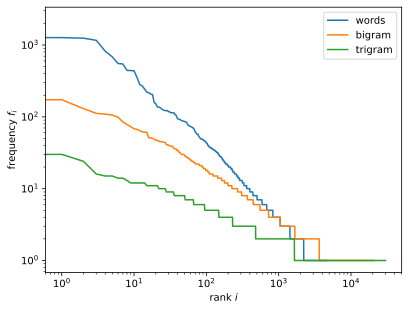

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

plt.plot(word_freqs, label="words")
plt.plot(bigram_freqs, label="bigram")
plt.plot(trigram_freqs, label="trigram")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("frequency $f_i$")
plt.xlabel("rank $i$")
plt.legend();

Estimating $a$:

In [15]:
import math

print("1:", (math.log(word_freqs[100]) - math.log(word_freqs[10])) / (math.log(100) - math.log(10)))
print("2:", (math.log(bigram_freqs[100]) - math.log(bigram_freqs[10])) / (math.log(100) - math.log(10)))
print("3:", (math.log(trigram_freqs[100]) - math.log(trigram_freqs[10])) / (math.log(100) - math.log(10)))

1: -1.007012981390835
2: -0.5772364076029304
3: -0.38021124171160603


**Remark.** Similar behavior and similar $a$'s have been observed for other novels. For example, *The Time Machine* and *Frankenstein* have similar values. Other types such as non-fiction or plays (*Romeo and Juliet*) have slightly but significantly different values.